## Vanilla KANs vs MLP

In [ ]:
!pip install pykan
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 2.7 MB/s eta 0:00:00


cpu


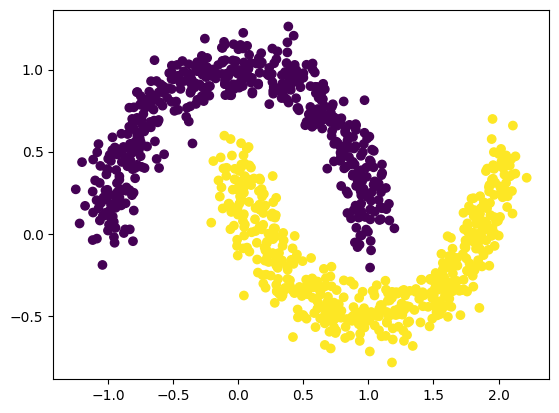

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

In [ ]:
model = KAN(width=[2,2], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=10);
print(f'Accuracy: {test_acc().item()}')

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-01 | test_loss: 1.57e-01 | reg: 5.95e+00 | : 100%|█| 10/10 [00:01<00:00,  6.05it

saving model version 0.1
Accuracy: 0.9990000128746033


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42,solver='lbfgs')

mlp.fit(train_input,train_label)

predictions = mlp.predict(test_input)

accuracy = accuracy_score(test_label, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)
formula1, formula2 = model.symbolic_formula()[0]

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
saving model version 0.3


In [ ]:
ex_round(formula1, 4)

-0.8716*x_2 + 0.3972*sin(3.0798*x_1 + 1.5614) + 0.7189

In [ ]:
ex_round(formula2, 4)

-0.8713*x_2 + 0.3971*sin(3.0817*x_1 + 1.5596) + 0.7188

In [ ]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor([0.5400])
test acc of the formula: tensor([0.5370])


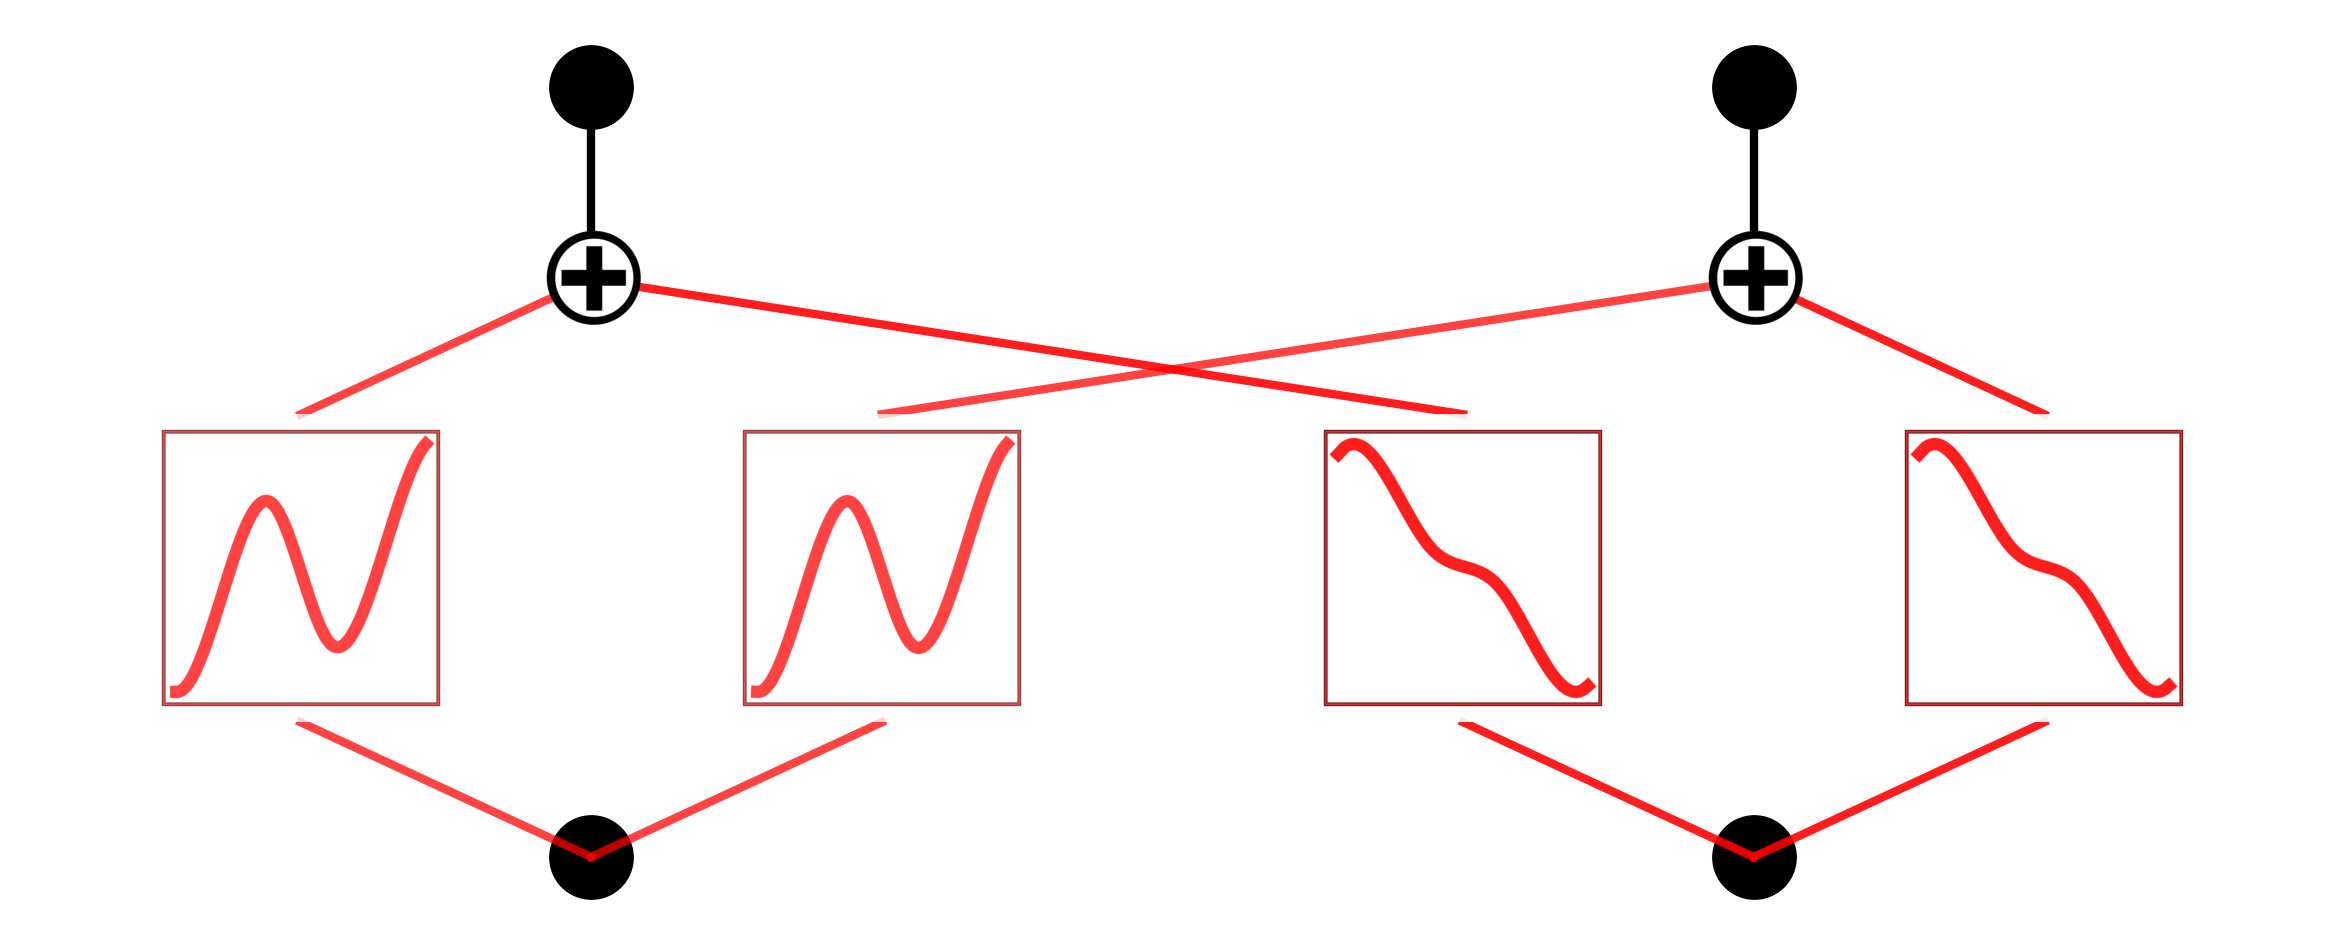

In [ ]:
model.plot(scale=3)

## Modelling a equation

#### f(x<sub>1</sub>,<sub>x2</sub>) = tanh(arctanh(x<sub>1</sub>)+arctanh(x<sub>2</sub>))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = KAN(width=[2,1,1], grid=10, k=3, device=device)

f = lambda x: (x[:,[0]]+x[:,[1]])/(1+x[:,[0]]*x[:,[1]])
dataset = create_dataset(f, n_var=2, ranges=[-0.9,0.9], device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.08e-03 | test_loss: 1.19e-03 | reg: 6.66e+00 | : 100%|█| 20/20 [00:09<00:00,  2.14it


saving model version 0.1


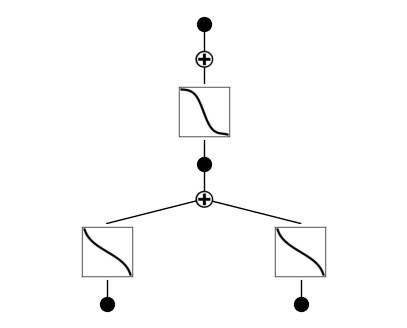

In [ ]:
model.fit(dataset, opt="LBFGS", steps=20)
model.plot(beta=10)


In [ ]:
model.suggest_symbolic(0,1,0,weight_simple=0.0)
model.fix_symbolic(0,0,0,'arctanh')
model.fix_symbolic(0,1,0,'arctanh')

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0  arctanh    0.999998 -16.322124           4                4  -16.322124
1      tan    0.999844 -12.554586           3                3  -12.554586
2   arccos    0.998866  -9.772251           4                4   -9.772251
3   arcsin    0.998866  -9.772100           4                4   -9.772100
4      exp    0.982260  -5.816056           2                2   -5.816056
r2 is 0.9999989867210388
saving model version 0.2
r2 is 0.9999977946281433
saving model version 0.3


tensor(1.0000)

In [ ]:
model.fit(dataset, opt="LBFGS", steps=20, update_grid=False)

| train_loss: 4.84e-04 | test_loss: 5.56e-04 | reg: 5.64e+00 | : 100%|█| 20/20 [00:05<00:00,  3.74it

saving model version 0.4


{'train_loss': [array(0.00098805, dtype=float32),
  array(0.00096045, dtype=float32),
  array(0.00085385, dtype=float32),
  array(0.00083841, dtype=float32),
  array(0.00083119, dtype=float32),
  array(0.0008243, dtype=float32),
  array(0.00079898, dtype=float32),
  array(0.00078359, dtype=float32),
  array(0.00075298, dtype=float32),
  array(0.00071663, dtype=float32),
  array(0.00067418, dtype=float32),
  array(0.000615, dtype=float32),
  array(0.00055027, dtype=float32),
  array(0.00053464, dtype=float32),
  array(0.0005072, dtype=float32),
  array(0.00049799, dtype=float32),
  array(0.00049096, dtype=float32),
  array(0.0004887, dtype=float32),
  array(0.00048531, dtype=float32),
  array(0.00048418, dtype=float32)],
 'test_loss': [array(0.00108366, dtype=float32),
  array(0.00105128, dtype=float32),
  array(0.00093604, dtype=float32),
  array(0.0009135, dtype=float32),
  array(0.00090733, dtype=float32),
  array(0.00090087, dtype=float32),
  array(0.00086595, dtype=float32),
  arra

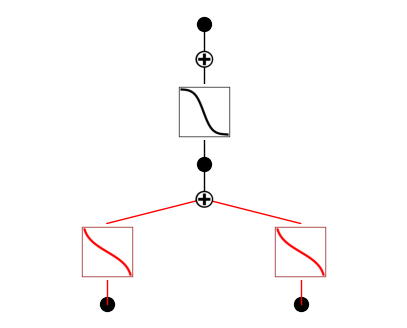

In [ ]:
model.plot(beta=10)

   function  fitting r2   r2 loss  complexity  complexity loss  total loss
0  gaussian    0.981837 -5.782062           3                3   -5.782062
1      tanh    0.965918 -4.874433           3                3   -4.874433
2    arctan    0.964444 -4.813340           4                4   -4.813340
3       abs    0.960566 -4.664032           3                3   -4.664032
4       sin    0.958788 -4.600449           2                2   -4.600449
Best value at boundary.
r2 is 0.965918242931366
saving model version 0.5


| train_loss: 6.08e-07 | test_loss: 6.30e-07 | reg: 0.00e+00 | : 100%|█| 2000/2000 [00:51<00:00, 39.


saving model version 0.6


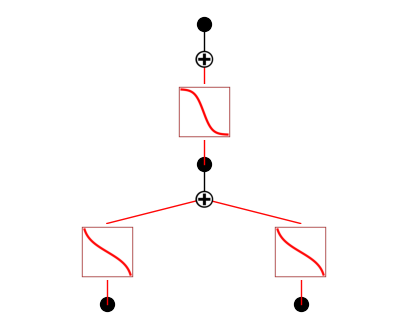

In [ ]:
model.suggest_symbolic(1,0,0,weight_simple=0.)
model.fix_symbolic(1,0,0,'tanh')
model.fit(dataset, opt="Adam", lr=1e-3, steps=2000, update_grid=False, singularity_avoiding=True);
model.plot()

In [ ]:
formula = model.symbolic_formula()[0][0]
nsimplify(ex_round(formula, 4))

tanh(atanh(x_1) + atanh(x_2))